In [84]:
from dataset.msc_summary_turns import MSC_Turns
import json
import pandas as pd
import numpy as np
import itertools
from ast import literal_eval
import matplotlib.pyplot as plt

In [2]:
# Load the MSC_Turns dataset

basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_personasummary/"
sessions = [1, 2, 3, 4]
subset = 'test'
msc_turns = MSC_Turns(basedir=basedir, sessions=sessions, subset=subset)

In [3]:
# Load the eval_results in dict

output_dir = "/Users/FrankVerhoef/Programming/PEX/output/"
resultsfile = "trained_base_reweighted_bart_evalresults.json"
with open (output_dir + resultsfile) as f:
    eval_results = json.loads(f.read())
eval_results = {literal_eval(k):v for k, v in eval_results.items()}
# list(eval_results.items())[:10]

# Use dict to create dataframe with all eval_results
df = pd.DataFrame.from_dict(eval_results, orient='index')
df.head()

convai_id  pred_fact  target_fact  nli_pred  nli_target  \
1 0 0    test_0          1            1  0.892353    0.993407   
    1    test_0          1            1  0.975239    0.985513   
    2    test_0          1            1  0.990986    0.981739   
    3    test_0          1            1  0.933112    0.985281   
    4    test_0          1            1  0.991065    0.976196   

                                            pred_persona  \
1 0 0  I live in a small town. I enjoy walking and ru...   
    1                           I like going to the gym.   
    2                        I am a computer programmer.   
    3                               I work in marketing.   
    4                              I love meat. I grill.   

                                          target_persona  len_p_split  \
1 0 0  I live semi-close towkr. I don't own a car. I ...          2.0   
    1                     I enjoy exercising at the gym.          1.0   
    2                         I'm a computer programmer.          1.0   
    3                            I have a marketing job.          1.0   
    4                             I like grilling steak.          2.0   

       len_t_split      terp  \
1 0 0          4.0  0.771092   
    1          1.0  0.667092   
    2          1.0  0.363080   
    3          1.0  0.756672   
    4          1.0  0.475379   

                                              terpscores    terpf1  \
1 0 0  [[0.9077003002166748, 1.0], [0.985699236392974...  0.666667   
    1                             [[0.7782739400863647]]  0.000000   
    2                             [[0.4538501501083374]]  1.000000   
    3                             [[0.9080064296722412]]  0.000000   
    4         [[0.7892205119132996, 0.7134682536125183]]  0.000000   

       terpprecision  terprecall  
1 0 0            1.0         0.5  
    1            0.0         0.0  
    2            1.0         1.0  
    3            0.0         0.0  
    4            0.0         0.0

In [4]:
###
### Add the item measurements to the dataframe
###

m = msc_turns.measurements()['allitem_measurements']
df_m = pd.DataFrame.from_records(m)
df_m.index = pd.MultiIndex.from_arrays(df_m[['session', 'dialog_id', 'turn_id']].values.T)
df_m = df_m.drop(['convai_id'], axis=1)
df = df.join(df_m, how='inner')
df

convai_id  pred_fact  target_fact  nli_pred  nli_target  \
1 0   0      test_0          1            1  0.892353    0.993407   
      1      test_0          1            1  0.975239    0.985513   
      2      test_0          1            1  0.990986    0.981739   
      3      test_0          1            1  0.933112    0.985281   
      4      test_0          1            1  0.991065    0.976196   
...             ...        ...          ...       ...         ...   
4 500 6   test_1014          1            1  0.985885    0.991852   
      7   test_1014          0            0  0.003272    0.003272   
      8   test_1014          0            0  0.003046    0.003046   
      9   test_1014          1            1  0.942601    0.959704   
      10  test_1014          0            0  0.000391    0.000391   

                                               pred_persona  \
1 0   0   I live in a small town. I enjoy walking and ru...   
      1                            I like going to the gym.   
      2                         I am a computer programmer.   
      3                                I work in marketing.   
      4                               I love meat. I grill.   
...                                                     ...   
4 500 6                         I have visited Denver once.   
      7                                                       
      8                                                       
      9                                      I have family.   
      10                                                      

                                             target_persona  len_p_split  \
1 0   0   I live semi-close towkr. I don't own a car. I ...          2.0   
      1                      I enjoy exercising at the gym.          1.0   
      2                          I'm a computer programmer.          1.0   
      3                             I have a marketing job.          1.0   
      4                              I like grilling steak.          2.0   
...                                                     ...          ...   
4 500 6                              I have visited Denver.          1.0   
      7                                                              NaN   
      8                                                              NaN   
      9              I will be doing a hike with my family.          1.0   
      10                                                             NaN   

          len_t_split      terp  \
1 0   0           4.0  0.771092   
      1           1.0  0.667092   
      2           1.0  0.363080   
      3           1.0  0.756672   
      4           1.0  0.475379   
...               ...       ...   
4 500 6           1.0  0.051771   
      7           NaN       NaN   
      8           NaN       NaN   
      9           1.0  1.000000   
      10          NaN       NaN   

                                                 terpscores    terpf1  \
1 0   0   [[0.9077003002166748, 1.0], [0.985699236392974...  0.666667   
      1                              [[0.7782739400863647]]  0.000000   
      2                              [[0.4538501501083374]]  1.000000   
      3                              [[0.9080064296722412]]  0.000000   
      4          [[0.7892205119132996, 0.7134682536125183]]  0.000000   
...                                                     ...       ...   
4 500 6                             [[0.06471318751573563]]  1.000000   
      7                                                 NaN       NaN   
      8                                                 NaN       NaN   
      9                                             [[1.0]]  0.000000   
      10                                                NaN       NaN   

          terpprecision  terprecall  session  dialog_id  turn_id  inputwords  \
1 0   0             1.0         0.5        1          0        0          37   
      1             0.0         0.0        1         

In [5]:
###
### Add the input sentence from dataset to the dataframe
###

df['history'] = [msc_turns[i][0].replace('\n', '<sep>') for i in range(len(msc_turns))]
df

convai_id  pred_fact  target_fact  nli_pred  nli_target  \
1 0   0      test_0          1            1  0.892353    0.993407   
      1      test_0          1            1  0.975239    0.985513   
      2      test_0          1            1  0.990986    0.981739   
      3      test_0          1            1  0.933112    0.985281   
      4      test_0          1            1  0.991065    0.976196   
...             ...        ...          ...       ...         ...   
4 500 6   test_1014          1            1  0.985885    0.991852   
      7   test_1014          0            0  0.003272    0.003272   
      8   test_1014          0            0  0.003046    0.003046   
      9   test_1014          1            1  0.942601    0.959704   
      10  test_1014          0            0  0.000391    0.000391   

                                               pred_persona  \
1 0   0   I live in a small town. I enjoy walking and ru...   
      1                            I like going to the gym.   
      2                         I am a computer programmer.   
      3                                I work in marketing.   
      4                               I love meat. I grill.   
...                                                     ...   
4 500 6                         I have visited Denver once.   
      7                                                       
      8                                                       
      9                                      I have family.   
      10                                                      

                                             target_persona  len_p_split  \
1 0   0   I live semi-close towkr. I don't own a car. I ...          2.0   
      1                      I enjoy exercising at the gym.          1.0   
      2                          I'm a computer programmer.          1.0   
      3                             I have a marketing job.          1.0   
      4                              I like grilling steak.          2.0   
...                                                     ...          ...   
4 500 6                              I have visited Denver.          1.0   
      7                                                              NaN   
      8                                                              NaN   
      9              I will be doing a hike with my family.          1.0   
      10                                                             NaN   

          len_t_split      terp  \
1 0   0           4.0  0.771092   
      1           1.0  0.667092   
      2           1.0  0.363080   
      3           1.0  0.756672   
      4           1.0  0.475379   
...               ...       ...   
4 500 6           1.0  0.051771   
      7           NaN       NaN   
      8           NaN       NaN   
      9           1.0  1.000000   
      10          NaN       NaN   

                                                 terpscores    terpf1  \
1 0   0   [[0.9077003002166748, 1.0], [0.985699236392974...  0.666667   
      1                              [[0.7782739400863647]]  0.000000   
      2                              [[0.4538501501083374]]  1.000000   
      3                              [[0.9080064296722412]]  0.000000   
      4          [[0.7892205119132996, 0.7134682536125183]]  0.000000   
...                                                     ...       ...   
4 500 6                             [[0.06471318751573563]]  1.000000   
      7                                                 NaN       NaN   
      8                                                 NaN       NaN   
      9                                             [[1.0]]  0.000000   
      10                                                NaN       NaN   

          terpprecision  terprecall  session  dialog_id  turn_id  inputwords  \
1 0   0             1.0         0.5        1          0        0          37   
      1             0.0         0.0        1         

Text(0.5, 0.98, 'Accuracy of predicted facts, per session')

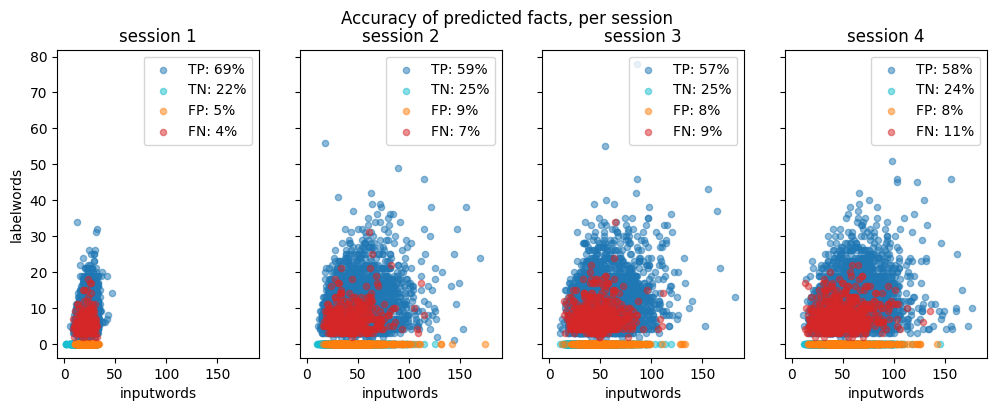

In [6]:
sessions = df['session'].unique()
fig, ax = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True, sharex=True)


selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
for i, session in enumerate(sessions):
    selected_session = df['session'] == session
    total = len(df[selected_session])
    for s in selection.keys():
        count = len(df[selected_session & selection[s]])
        label = f"{s}: {count/total:.0%}"
        df[selected_session & selection[s]].plot.scatter('inputwords', 'labelwords', c=col[s], alpha=0.5, label=label, ax=ax[i])
    ax[i].set_title(f"session {session}")

fig.suptitle("Accuracy of predicted facts, per session")

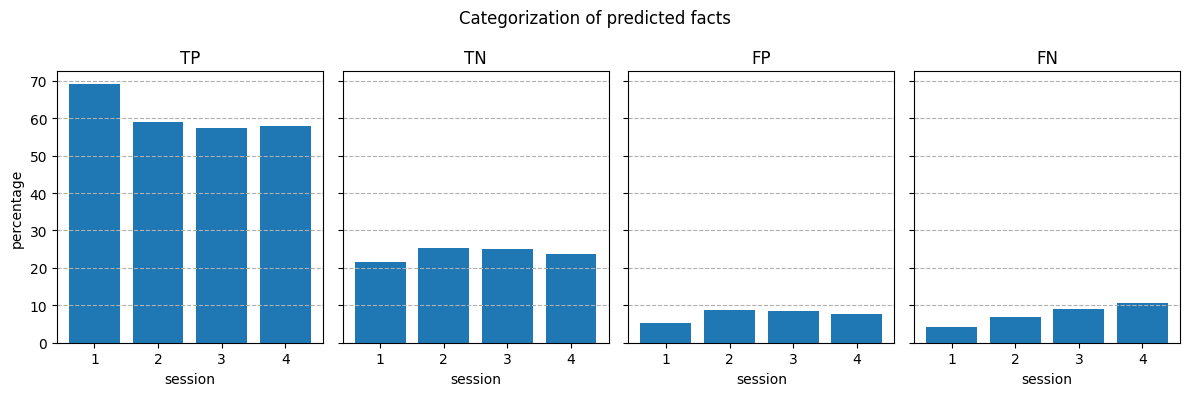

In [7]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
fig, ax = plt.subplots(ncols=len(selection.keys()), figsize=(12,4), sharey=True, sharex=True)

session_total = df.groupby(['session'])['turn_id'].count().values

for i, s in enumerate(selection.keys()):
    category_count = df[selection[s]].groupby(['session'])['turn_id'].count()
    perc = category_count / session_total * 100
    ax[i].bar(x=sessions, height=perc)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(s)
    ax[i].set_xticks(sessions)
    ax[i].set_xlabel("session")
    if i == 0:
        ax[i].set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts")
fig.tight_layout()

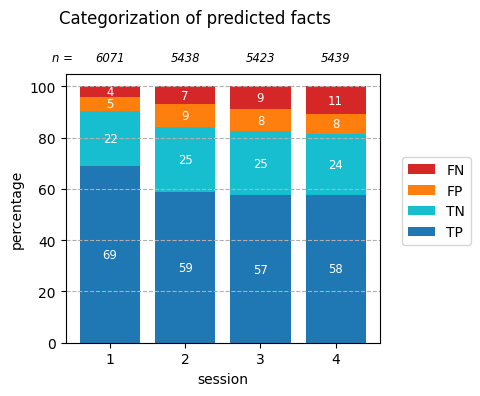

In [8]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
fig, ax = plt.subplots(figsize=(4,4))

session_total = df.groupby(['session'])['turn_id'].count().values
bottom = np.zeros(len(selection.keys()))

for s in selection.keys():
    category_count = df[selection[s]].groupby(['session'])['turn_id'].count().values
    perc = category_count / session_total * 100
    ax.bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
    for session, b, p in zip(sessions, bottom, perc):
        ax.text(session, b + p/2, f"{p:.0f}", horizontalalignment='center', verticalalignment='center', fontsize='small', c='w')
    bottom += perc

ax.text(0.5, 110, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
for session, t in zip(sessions, session_total):
    ax.text(session, 110, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(sessions)
ax.set_xlabel("session")
ax.set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
fig.tight_layout()

Session total:  [82  2  0  0]
Session total:  [2056  216  134  118]
Session total:  [3683  810  595  520]
Session total:  [ 246 1204 1109  999]
Session total:  [   4 1190 1171 1139]
Session total:  [   0  871 1009  940]
Session total:  [   0  838 1025 1161]
Session total:  [  0 231 290 416]
Session total:  [  0  76  90 146]


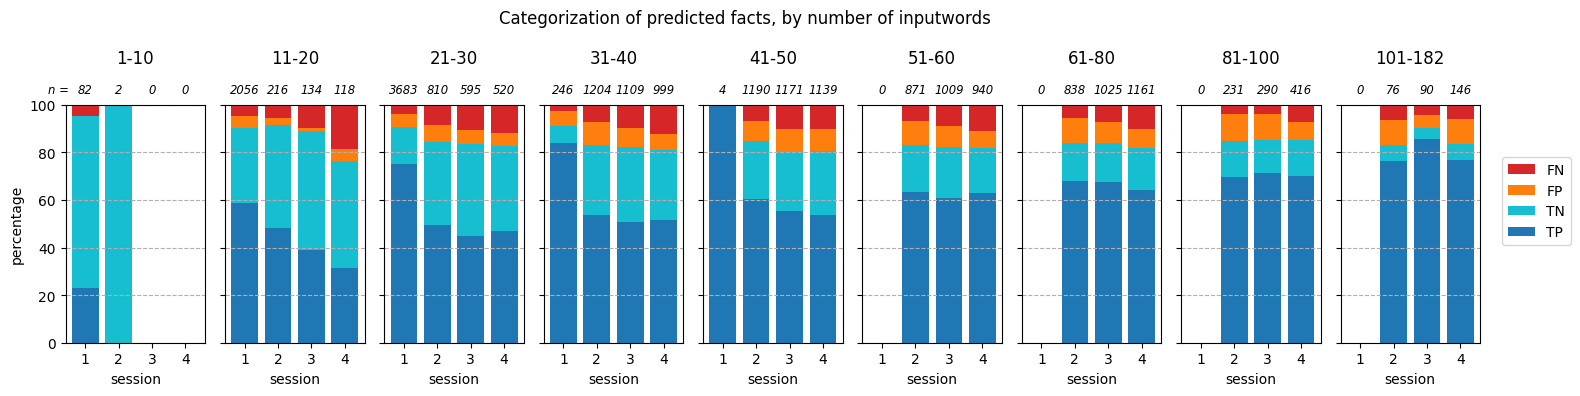

In [9]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
max_inputwords = df['inputwords'].max()
bin_boundaries = [0, 10, 20, 30, 40, 50, 60, 80, 100, max_inputwords]
# bin_boundaries = [0, 20, 40, 200]
bins = [(lower + 1, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, ax = plt.subplots(ncols=len(bins), figsize=(15, 4), sharey=True)


for i, (lower, upper) in enumerate(bins):
    selected_bin = (df['inputwords'] >= lower) & (df['inputwords'] <= upper)
    session_total = np.array([len(df[selected_bin & (df['session'] == session)]) for session in sessions])
    print("Session total: ", session_total)
    bottom = np.zeros(len(selection.keys()))

    for s in selection.keys():
        category_count = np.array([len(df[selected_bin & selection[s] & (df['session'] == session)]) for session in sessions])
        # print("Category count: ", category_count)
        perc = category_count / np.maximum(session_total, np.ones_like(session_total)) * 100
        ax[i].bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
        bottom += perc

    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"{lower}-{upper}", pad=30)
    for s, t in enumerate(session_total):
        ax[i].text(s + 1, 105, session_total[s], horizontalalignment='center', fontsize='small', fontstyle='italic')
    ax[i].set_xticks(sessions)
    ax[i].set_xlabel("session")
    if i == 0:
        ax[i].text(0.5, 105, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        ax[i].set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts, by number of inputwords")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
fig.tight_layout()

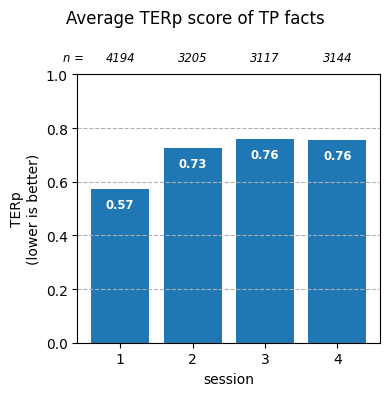

In [80]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, ax = plt.subplots(figsize=(4,4))

terp_mean = df[selection["TP"]].groupby(['session'])['terp'].mean().values
terp_count =  df[selection["TP"]].groupby(['session'])['terp'].count().values

ax.bar(x=sessions, height=terp_mean)
for session, m in zip(sessions, terp_mean):
    ax.text(session, m - 0.07, f"{m:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

ax.text(0.5, 1.05, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
for session, t in zip(sessions, terp_count):
    ax.text(session, 1.05, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(sessions)
ax.set_xlabel("session")
ax.set_ylim(0,1)
ax.set_ylabel("TERp\n(lower is better)")

fig.suptitle("Average TERp score of TP facts")
fig.tight_layout()

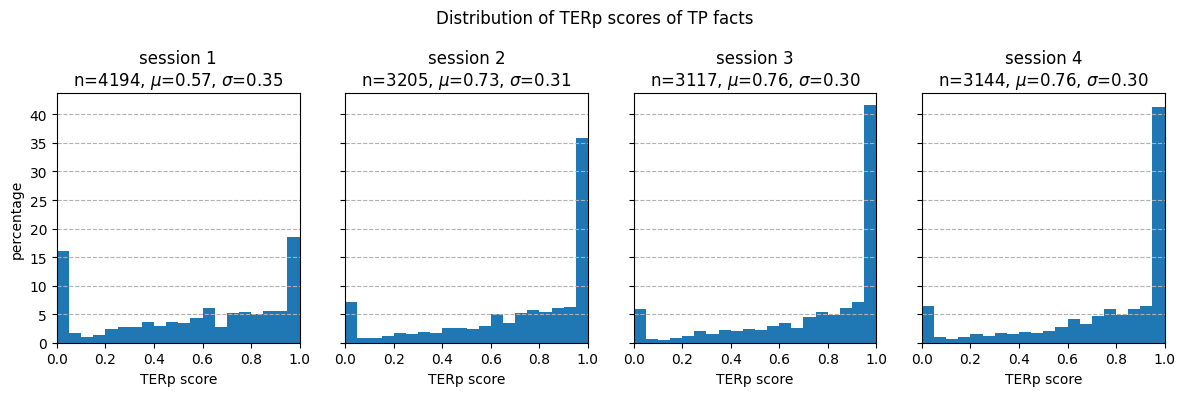

In [69]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]['terp']
    terp_mean = df_subset.mean()
    terp_std = df_subset.std()
    terp_count =  df_subset.count()

    ax.hist(df_subset, bins=20, range=(0,1), density=True)

    ax.set_title(f"session {session}\nn={terp_count}, " + r"$\mu$" + f"={terp_mean:.2f}, " + r"$\sigma$" + f"={terp_std:.2f}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("TERp score")
    if session == 1:
        ax.set_yticks(np.array(range(11)))
        ax.set_yticklabels(np.array(range(11))*5)
        ax.set_ylabel("percentage")

fig.suptitle("Distribution of TERp scores of TP facts")
fig.tight_layout()

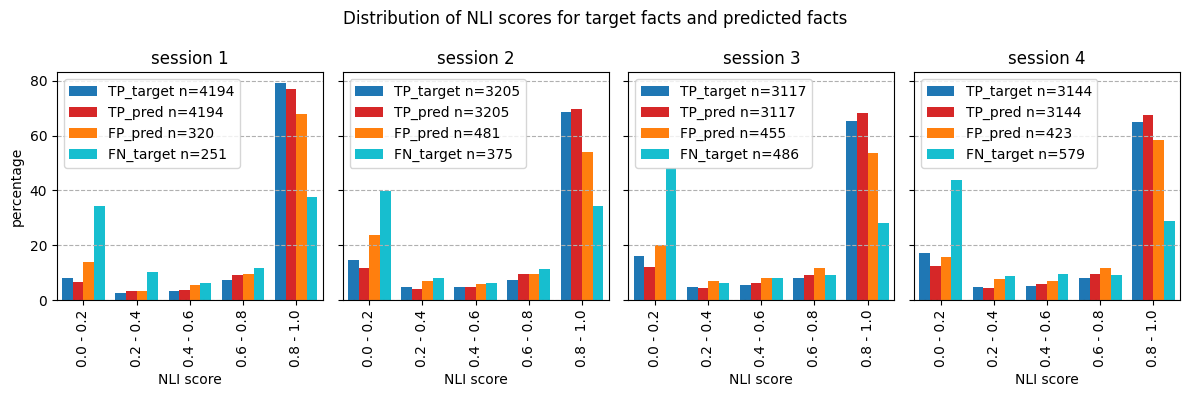

In [143]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}

bin_boundaries = [0, 0.2, 0.4, 0.6, 0.8, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    for i, s in enumerate(colors.keys()):
        df_subset = df[selection[s[:2]] & (df['session'] == session)]
        nli_col = 'nli' + s[2:]
        num_perbin = np.array([
            df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].count()
            for lower, upper in bins
        ])
        num_total =  sum(num_perbin)

        ax.bar(x=x_range+0.2+i*0.2, height=num_perbin/num_total*100, color=colors[s], width=0.2, label=f"{s} n={num_total}")

    ax.set_title(f"session {session}")
    ax.legend()
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0, len(bins))
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_xticks(x_range + 0.5)
    ax.set_xticklabels(f"{lower:.1f} - {upper:.1f}" for lower, upper in bins)
    ax.set_xlabel("NLI score")
    if session == 1:
        # ax.set_yticks(np.array(range(21)))
        # ax.set_yticklabels(np.array(range(21))*2)
        ax.set_ylabel("percentage")

fig.suptitle("Distribution of NLI scores for target facts and predicted facts")
fig.tight_layout()

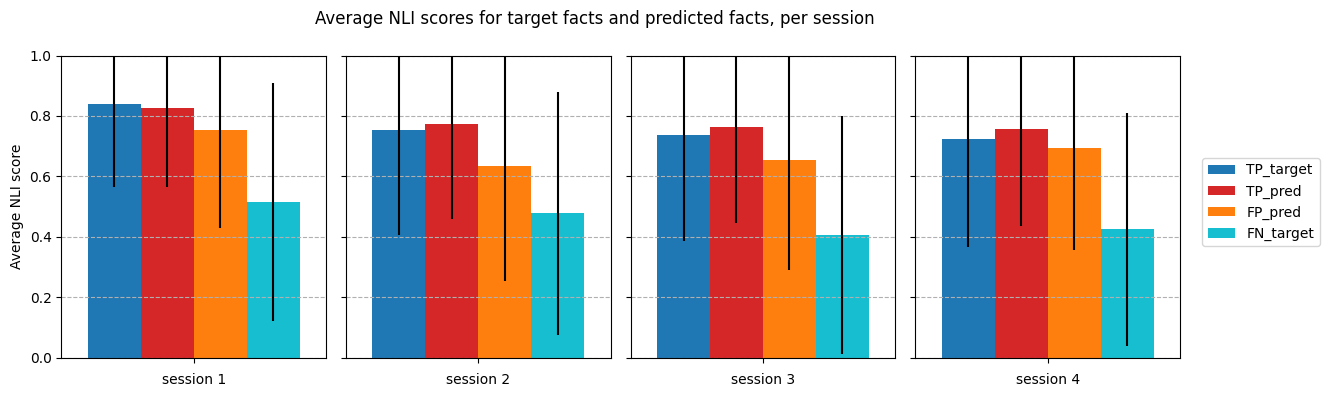

In [160]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}

bin_boundaries = [0, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    for i, s in enumerate(colors.keys()):
        df_subset = df[selection[s[:2]] & (df['session'] == session)]
        nli_col = 'nli' + s[2:]
        avg_perbin = np.array([
            df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].mean()
            for lower, upper in bins
        ])
        std_perbin = np.array([
            df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].std()
            for lower, upper in bins
        ])
        ax.bar(x=x_range+0.2+i*0.2, height=avg_perbin, yerr=std_perbin, color=colors[s], width=0.2, label=f"{s}")

    ax.set_xlabel(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0, len(bins))
    ax.set_xticks(x_range + 0.5)
    ax.set_xticklabels("")
    if session == 1:
        ax.set_ylim(0,1)
        ax.set_ylabel("Average NLI score")

fig.suptitle("Average NLI scores for target facts and predicted facts, per session")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

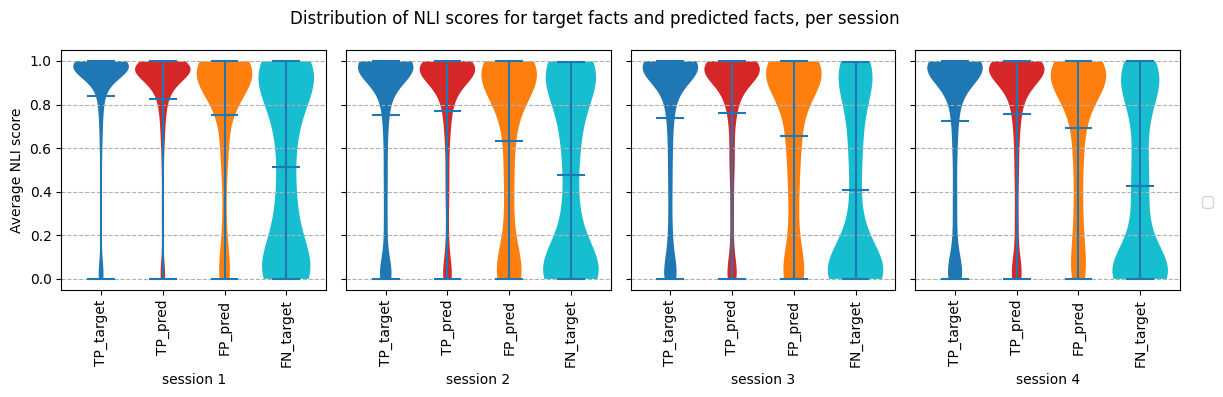

In [188]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}

bin_boundaries = [0, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    data = [
        df[selection[s[:2]] & (df['session'] == session)]['nli' + s[2:]].values
        for s in colors.keys()
    ]

    plots = ax.violinplot(data, showmeans=True, widths=0.9)

    for pc, color in zip(plots['bodies'], colors.values()):
        pc.set_facecolor(color)
        pc.set_alpha(1)
    ax.set_xlabel(f"session {session}")
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(colors.keys())
    ax.grid(which='major', axis='y', linestyle='--')
    if session == 1:
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel("Average NLI score")

fig.suptitle("Distribution of NLI scores for target facts and predicted facts, per session")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

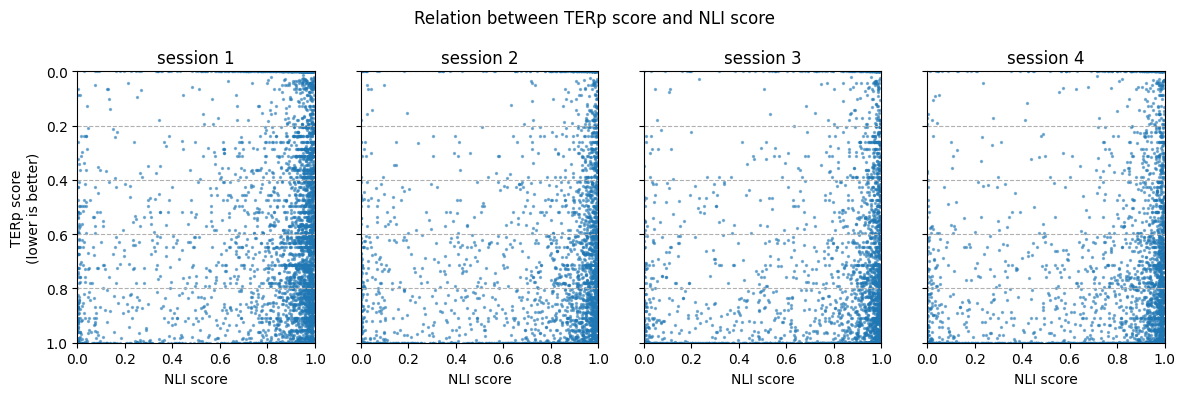

In [83]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()

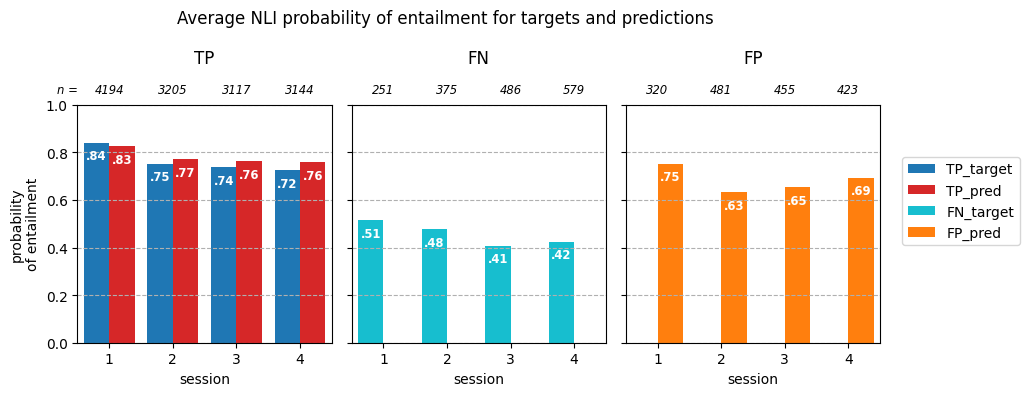

In [146]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}
fig, ax = plt.subplots(ncols=3, figsize=(9,4), sharey=True)

for s, a in zip(["TP", "FN", "FP"], ax):

    if s == 'TP' or s == 'FN':
        nli_tgt_mean = df[selection[s]].groupby(['session'])['nli_target'].mean().values
        count = df[selection[s]].groupby(['session'])['nli_target'].count().values
        a.bar(x=sessions - 0.2, height=nli_tgt_mean, width=0.4, color=colors[f"{s}_target"], label=f"{s}_target")
        for session, m in zip(sessions, nli_tgt_mean):
            a.text(session - 0.2, m - 0.07, (f"{m:.2f}")[1:], horizontalalignment='center', fontweight='bold', fontsize='small', c='w')
    if s == 'TP' or s == 'FP':
        nli_pred_mean = df[selection[s]].groupby(['session'])['nli_pred'].mean().values
        count = df[selection[s]].groupby(['session'])['nli_pred'].count().values
        a.bar(x=sessions + 0.2, height=nli_pred_mean, width=0.4, color=colors[f"{s}_pred"], label=f"{s}_pred")
        for session, m in zip(sessions, nli_pred_mean):
            a.text(session + 0.2, m - 0.07, (f"{m:.2f}")[1:], horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

    for session, t in zip(sessions, count):
        a.text(session, 1.05, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
    a.set_title(s, pad=30)
    a.grid(which='major', axis='y', linestyle='--')
    a.set_xlim(0.5, 4.5)
    a.set_xticks(sessions)
    a.set_xlabel("session")
    if s == "TP":
        a.text(0.5, 1.05, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        a.set_ylabel("probability\nof entailment")
        a.set_ylim(0, 1)
    
fig.suptitle("Average NLI probability of entailment for targets and predictions")
# handles, labels = ax[0].get_legend_handles_labels()
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

## Take sample from dataset for analysis

In [12]:
max_inputwords = df['inputwords'].max()
bin_boundaries = [0, 10, 20, 30, 40, 50, 60, 80, 100, max_inputwords]
bins = [(lower + 1, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

samples = []
for s in selection.keys():
    for lower, upper in bins:
        subset = (selection[s] & (df['inputwords'] >= lower) & (df['inputwords'] <= upper))
        samples.append(df[subset].sample(n=min(10, len(df[subset])), axis=0, replace=False, ignore_index=False).index)

sampled = pd.MultiIndex.from_tuples([id for indexlist in samples for id in indexlist])
sampled

MultiIndex([(1, 311,  6),
            (1, 431,  4),
            (1, 381,  3),
            (1, 424,  0),
            (1,  13,  0),
            (1, 455,  9),
            (1, 356,  8),
            (1, 473,  0),
            (1, 419, 11),
            (1, 445,  3),
            ...
            (4, 463,  3),
            (3,  18,  9),
            (2, 360,  6),
            (4, 210,  3),
            (4,  23,  4),
            (2, 155,  7),
            (4, 463,  5),
            (2, 196, 10),
            (3, 495,  7),
            (2, 308,  8)],
           length=344)

In [13]:
output_dir = "/Users/FrankVerhoef/Programming/PEX/output/"
filename = "sample_newnli.csv"

df.loc[sampled].to_csv(output_dir + filename, sep='\t') 

In [17]:
# Load the saved csv file (with additional columns)
df_index = pd.read_csv(output_dir + "sample_index.csv", sep=';')

# Extract the index
sampled_index = pd.MultiIndex.from_arrays(df_index[['i0', 'i1', 'i2']].values.T)

In [34]:
# Save specified columns
df.loc[sampled_index][['nli_pred', 'nli_target']].to_csv(output_dir + 'new_nli.csv', sep='\t') 